In [75]:
import os
from google.cloud import bigquery
import pandas as pd
# import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, coo_matrix

from src.util.preprocess import get_connectivity
from src.util.visualization import visualize_graph

In [76]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str('../access/apikey.json')


In [77]:
import PyQt6

In [78]:
client = bigquery.Client()

QUERY = ("SELECT GKGRECORDID, V2Persons FROM `gdelt-bq.gdeltv2.gkg` WHERE DATE>20230701000000 and DATE < 20230715000000 and V2Persons like '%Albanese%' and V2Locations like '%Australia%' limit 250;")

In [79]:
data_frame = pd.read_gbq(QUERY)

In [80]:
data_frame.head()

,GKGRECORDID,V2Persons
0,20230714053000-1126,"Bob Hawke,1228;Peter Dutton,7970;Jack Waterfor..."
1,20230714053000-897,"Keegan Carroll,732;Keegan Carroll,859;Phil Low..."
2,20230714053000-1103,"Josh Frydenberg,356;Andrew Leigh,3029;Phil Low..."
3,20230714053000-1208,"Philip Lowe,668;Philip Lowe,795;Philip Lowe,20..."
4,20230714053000-1219,"Andrew Leigh,3029;Keegan Carroll,732;Keegan Ca..."


In [81]:
connection_database = (get_connectivity(data_frame))


 n(entries) = 250
0/250
1/250
2/250
3/250
4/250
5/250
6/250
7/250
8/250
9/250
10/250
11/250
12/250
13/250
14/250
15/250
16/250
17/250
18/250
19/250
20/250
21/250
22/250
23/250
24/250
25/250
26/250
27/250
28/250
29/250
30/250
31/250
32/250
33/250
34/250
35/250
36/250
37/250
38/250
39/250
40/250
41/250
42/250
43/250
44/250
45/250
46/250
47/250
48/250
49/250
50/250
51/250
52/250
53/250
54/250
55/250
56/250
57/250
58/250
59/250
60/250
61/250
62/250
63/250
64/250
65/250
66/250
67/250
68/250
69/250
70/250
71/250
72/250
73/250
74/250
75/250
76/250
77/250
78/250
79/250
80/250
81/250
82/250
83/250
84/250
85/250
86/250
87/250
88/250
89/250
90/250
91/250
92/250
93/250
94/250
95/250
96/250
97/250
98/250
99/250
100/250
101/250
102/250
103/250
104/250
105/250
106/250
107/250
108/250
109/250
110/250
111/250
112/250
113/250
114/250
115/250
116/250
117/250
118/250
119/250
120/250
121/250
122/250
123/250
124/250
125/250
126/250
127/250
128/250
129/250
130/250
131/250
132/250
133/250
134/250
135/250
136/

In [82]:
connection_database.to_csv('../data/processed/connection_dataset.csv')
edge_counts = connection_database.groupby(['Source', 'Target']).size().reset_index().rename(columns = {0:'count'})
edge_counts.to_csv('../data/processed/edge_counts.csv', index_label='ix')
edge_counts.head()

,Source,Target,count
0,Adam Boyton,Anthony Albanese,1
1,Adam Boyton,Dame Quentin Bryce,1
2,Adam Boyton,Gail Kelly,1
3,Adam Boyton,Julia Gillard,1
4,Adam Boyton,Justice Susan Kiefel,1


In [83]:
weights = edge_counts['count'].values.astype(float)
weights /= weights.max()

edge_counts.insert(3, 'weight', weights)
edge_counts.to_csv('processed_edges.csv', index=None)

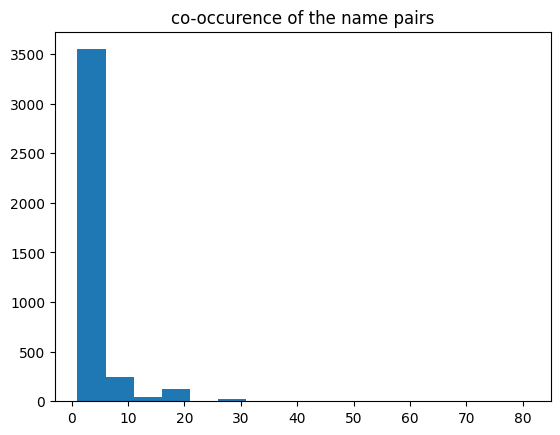

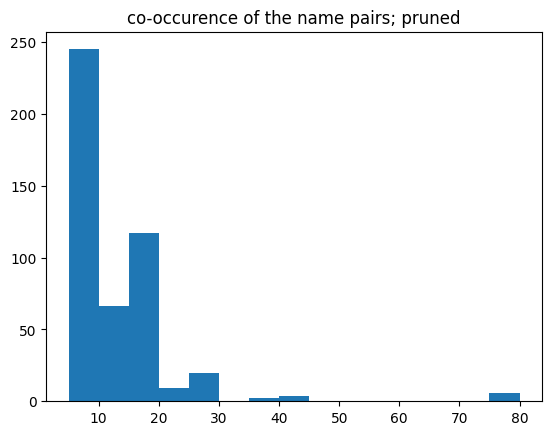

In [84]:
edge_counts = pd.read_csv('../data/processed/processed_edges.csv')
plt.hist(edge_counts['count'].values, bins=range(min(edge_counts['count'].values), max(edge_counts['count'].values) + 5, 5))
plt.title('co-occurence of the name pairs')
plt.show()


data = edge_counts.drop(edge_counts[edge_counts['count']<5].index)
plt.hist(data['count'].values, bins=range(min(data['count'].values), max(data['count'].values) + 5, 5))
plt.title('co-occurence of the name pairs; pruned')
plt.show()

In [85]:
# sum_outgoing_edges = edge_counts.groupby('Target')['count'].transform('sum')
# sum_outgoing_edges

In [86]:
# df_sorted = edge_counts.groupby('Source').apply(lambda x: x.sort_values('count', ascending=False))
# df_sorted

In [87]:
# df_sorted = edge_counts.sort_values(by=['Target', 'weight'], ascending=[True, False])
#
# # Take the top 5 rows for each 'source' group
# df_filtered = df_sorted.groupby('Target').head(5).reset_index(drop=True)

In [88]:
le = LabelEncoder()
le.fit(np.union1d(data.Source.values, data.Target.values))


LabelEncoder()

In [89]:
sources = le.transform(data.Source.values)
targets = le.transform(data.Target.values)

In [90]:
adj_mat = csr_matrix(coo_matrix( (data.weight.values, (sources, targets))))
adj_mat += adj_mat.T
adj_mat /= 2.
# adj_mat[adj_mat < adj_mat.max()*0.5] = 0
print(adj_mat.shape)

(76, 76)


/Users/damithasanka/PycharmProjects/gdelt/venv/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


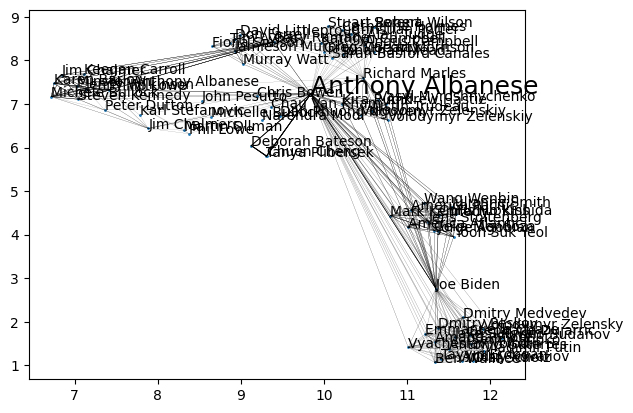

In [91]:
visualize_graph(adj_mat, np.union1d(data.Source.values, data.Target.values), le.transform(np.union1d(data.Source.values, data.Target.values)))



Let's sparsify the graph a bit more so that we can see clearer

In [92]:
adj_mat = adj_mat.toarray()

In [93]:
for i in range(adj_mat.shape[0]):
    row = adj_mat[i]
    sorted_indices = np.argsort(row)
    cutoff = np.argsort(row)[2]
    # print(cutoff)
    # print(adj_mat[i])
    adj_mat[i][adj_mat[i]>cutoff] = 0
    adj_mat[:, i][adj_mat[i]>cutoff]=0
    # print(adj_mat[i])

In [94]:
adj_mat = csr_matrix(adj_mat)

/Users/damithasanka/PycharmProjects/gdelt/venv/lib/python3.10/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


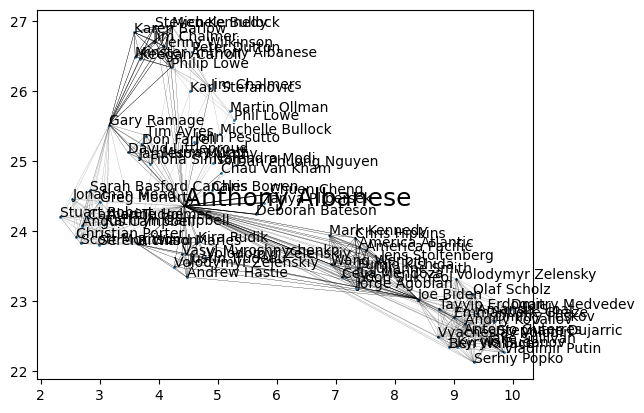

In [95]:
visualize_graph(adj_mat, np.union1d(data.Source.values, data.Target.values), le.transform(np.union1d(data.Source.values, data.Target.values)))